## Cuantización vectorial 

La mayoría de los embeddings vectoriales se almacenan como números de punto flotante (64 bits en Python). Podemos utilizar la cuantización para reducir el tamaño de los embeddings.


In [ ]:
# Cargamos los vectores desde movies.json, {movie: [vector]}
import json

with open('embeddings/peliculas_text-embedding-3-small-1536.json') as f:
    movies = json.load(f)

movies['La Sirenita'][0:10]

[0.00852360762655735,
 -0.0023003225214779377,
 -0.0015744429547339678,
 -0.00015070763765834272,
 0.006029035430401564,
 0.002567597897723317,
 -0.004060251638293266,
 0.028112130239605904,
 -0.027434447780251503,
 -0.03339337930083275]

## Cuantización Escalar


In [20]:
def scalar_quantization(embeddings: list[list[float]], num_levels=256, min_level=-128, max_level=127):
    # Aplanamos los embeddings para encontrar el mínimo y máximo global
    flattened_embeddings = [
        number for embedding in embeddings for number in embedding
    ]
    min_val = min(flattened_embeddings)
    max_val = max(flattened_embeddings)
    
    # Normalizamos los embeddings a [0, 1]
    normalized_embeddings = [
        [(number - min_val) / (max_val - min_val) for number in embedding]
        for embedding in embeddings
    ]
    
    # Cuantizamos los valores normalizados al número de niveles especificado
    quantized_embeddings = [
        [int(round(number * (num_levels - 1)) * (max_level - min_level) / (num_levels - 1) + min_level)
        for number in embedding]
        for embedding in normalized_embeddings
    ]
    
    return quantized_embeddings

quantized_embeddings = scalar_quantization(list(movies.values()))
movies_1byte = {
    movie: quantized_embedding
    for movie, quantized_embedding in zip(movies.keys(), quantized_embeddings)
}

# Comprobamos los primeros 10 bytes del vector cuantizado para 'El Rey León'
print(movies_1byte['El Rey León'][0:10])

[-5, -1, -23, 12, -28, 21, -29, 63, -22, 1]


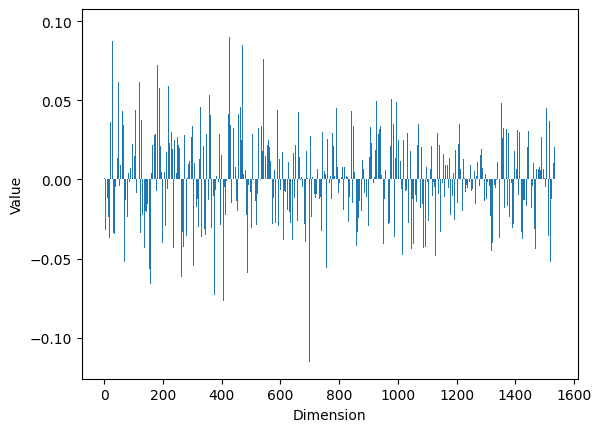

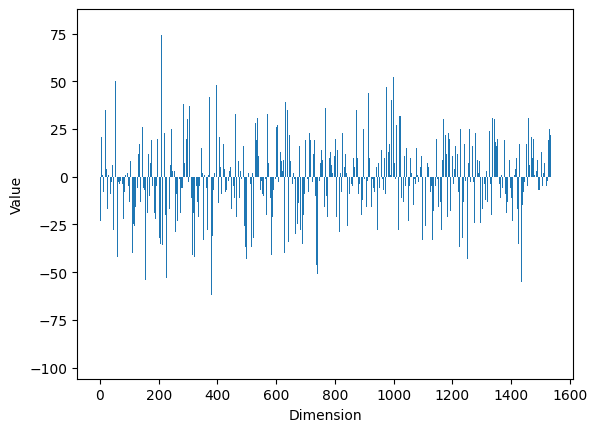

In [21]:
import matplotlib.pyplot as plt


def render_vector(vector):
    """Visualizar los valores del vector en un bar chart"""
    plt.bar(range(len(vector)), vector)
    plt.xlabel('Dimension')
    plt.ylabel('Value')
    plt.show()

render_vector(movies['El Rey León'])
render_vector(movies_1byte['El Rey León'])

In [22]:
# 10 peliculas mas similares a El Rey León
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(movie, movies):
    movie_vec = movies[movie]
    similarities = {k: cosine_similarity([movie_vec], [v])[0][0] for k, v in movies.items()}
    closest = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(closest, columns=['película', 'similitud'])
    return df

most_similar('El Rey León', movies_1byte)[:10]

,película,similitud
0,El Rey León,1.000000
1,El Libro de la selva,0.504646
2,La Bella y la Bestia,0.497284
3,Cenicienta,0.459918
4,Encanto,0.456298
5,La gran película de Piglet,0.452952
6,Aladdín,0.450035
7,Frozen: El reino de hielo,0.447100
8,"Merlín, el encantador",0.438813
9,El Jorobado de Notre Dame,0.422015


In [23]:
most_similar('El Rey León', movies)[:10]

,película,similitud
0,El Rey León,1.000000
1,El Libro de la selva,0.503496
2,La Bella y la Bestia,0.494477
3,Cenicienta,0.456724
4,Encanto,0.454299
5,La gran película de Piglet,0.450369
6,Aladdín,0.448663
7,Frozen: El reino de hielo,0.445374
8,"Merlín, el encantador",0.436161
9,El Jorobado de Notre Dame,0.421666


## Cuantización Binaria

La forma más extrema de cuantización consiste en almacenar los embeddings como números binarios, estableciendo cada dimensión a 0 o 1, basándose en un umbral.

In [24]:
def binary_quantization(embeddings):
    """Convertimos un float32 en un bit basado en el umbral proporcionado"""
    
    # encontramos la media de todas las dimensiones
    flattened_embeddings = [
        number for embedding in embeddings for number in embedding
    ]
    mean_val = sum(flattened_embeddings) / len(flattened_embeddings)
    
    # cuantizamos los embeddings a 1 bit
    quantized_embeddings = [
        [1 if number > mean_val else 0 for number in embedding]
        for embedding in embeddings
    ]
    return quantized_embeddings

binary_quantized_embeddings = binary_quantization(list(movies.values()))
movies_1bit = {
    movie: quantized_embedding
    for movie, quantized_embedding in zip(movies.keys(), binary_quantized_embeddings)
}

# Comprobamos los primeros 10 bits del vector cuantizado para 'El Rey León'
print(movies_1bit['El Rey León'][0:10])

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


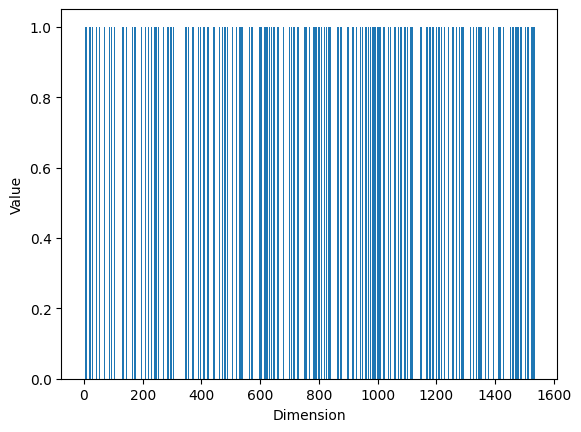

In [25]:
render_vector(movies_1bit['El Rey León'])

In [26]:
most_similar('El Rey León', movies_1bit)[:10]

,película,similitud
0,El Rey León,1.000000
1,El Libro de la selva,0.682991
2,La Bella y la Bestia,0.665408
3,Aladdín,0.653114
4,Encanto,0.645397
5,Lo mejor de Winnie the Pooh,0.641925
6,"Merlín, el encantador",0.641925
7,La gran película de Piglet,0.641107
8,Descubriendo a los Robinsons,0.641103
9,"Las aventuras de Bongo, Mickey y las judías má...",0.640358


## Comparación de tamaño

In [28]:
import sys

pd.DataFrame({
    'float64': [sys.getsizeof(movies['El Rey León'])],
    'int8': [sys.getsizeof(movies_1byte['El Rey León'])],
    'int1': [sys.getsizeof(movies_1bit['El Rey León'])],
})

,float64,int8,int1
0,12728,12728,12728


In [29]:
# Ahora convertimos cada uno a arrays de numpy del tipo apropiado
import numpy as np
def convert_to_numpy(movies, dtype):
    return {
        movie: np.array(embedding, dtype=dtype)
        for movie, embedding in movies.items()
    }
movies_float64 = convert_to_numpy(movies, np.float64)
movies_int8 = convert_to_numpy(movies_1byte, np.int8)
movies_int1 = convert_to_numpy(movies_1bit, np.int8)

pd.DataFrame({
    'float64': [sys.getsizeof(movies_float64['El Rey León'])],
    'int8': [sys.getsizeof(movies_int8['El Rey León'])],
    'int1': [sys.getsizeof(movies_int1['El Rey León'])],
})

,float64,int8,int1
0,12400,1648,1648


In [30]:
sys.getsizeof(movies_float64['El Rey León'])/sys.getsizeof(movies_int8['Mulan'])

7.524271844660194

## Recursos

* [Scalar quantization 101](https://www.elastic.co/search-labs/blog/scalar-quantization-101)
* [Product quantization 101](https://www.pinecone.io/learn/series/faiss/product-quantization/)
* [Binary and scalar quantization](https://huggingface.co/blog/embedding-quantization)